In [1]:
!pip3 install -e ..
!pip3 install timm
!pip3 install wget

Obtaining file:///w251_project
  Found existing installation: mids-plane-classification 0.0.1
    Can't uninstall 'mids-plane-classification'. No files were found to uninstall.
  Running setup.py develop for mids-plane-classification


In [2]:
import tensorrt as trt
import timm
import time
import numpy as np
import torch.backends.cudnn as cudnn
from mids_plane_classification.loaders.dataloader import PlaneDataModule
from torch2trt import torch2trt
import torch
import torchvision.models as models
from mids_plane_classification.models.resnet18 import AircraftResNet18
import matplotlib.pyplot as plt

In [3]:
# set the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('running on device ' + str(device))

running on device cuda:0


In [4]:
chk_path ='/w251_project/mids_plane_classification/models/checkpoints/model_best.pth.tar'
print('loading checkpoint:  ' + chk_path)
checkpoint = torch.load(chk_path)
arch = checkpoint['arch']
print('using model:  ' + arch)
model = AircraftResNet18()
model.load_state_dict(checkpoint['state_dict'])
epoch = checkpoint['epoch']

loading checkpoint:  /w251_project/mids_plane_classification/models/checkpoints/model_best.pth.tar
using model:  resnet18


In [5]:
# create optimized tensorRt engine
data = torch.randn((1,3,256,256)).cuda().half()
model_trt_fp16 = torch2trt(model.cuda().half().eval(), [data], fp16_mode=True)
output_trt_fp16 = model_trt_fp16(data)
output = model(data)
print(output.flatten())
print(output_trt_fp16.flatten())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /media/nvidia/NVME/pytorch/pytorch-v1.9.0/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor([ -9.8203, -19.5000,  -7.6875,   2.9512,  22.7344,  12.8281,   3.7910,
        -29.6250,  34.2188,  -3.8926,  -4.7852], device='cuda:0',
       dtype=torch.float16, grad_fn=<ViewBackward>)
tensor([ -9.8438, -19.5156,  -7.7031,   2.9434,  22.7656,  12.8516,   3.8086,
        -29.6562,  34.2500,  -3.9082,  -4.7930], device='cuda:0',
       dtype=torch.float16)


In [6]:
#save the fp16 model
torch.save(model_trt_fp16.state_dict(), '/w251_project/mids_plane_classification/resnet18_trt_fp16.pth')

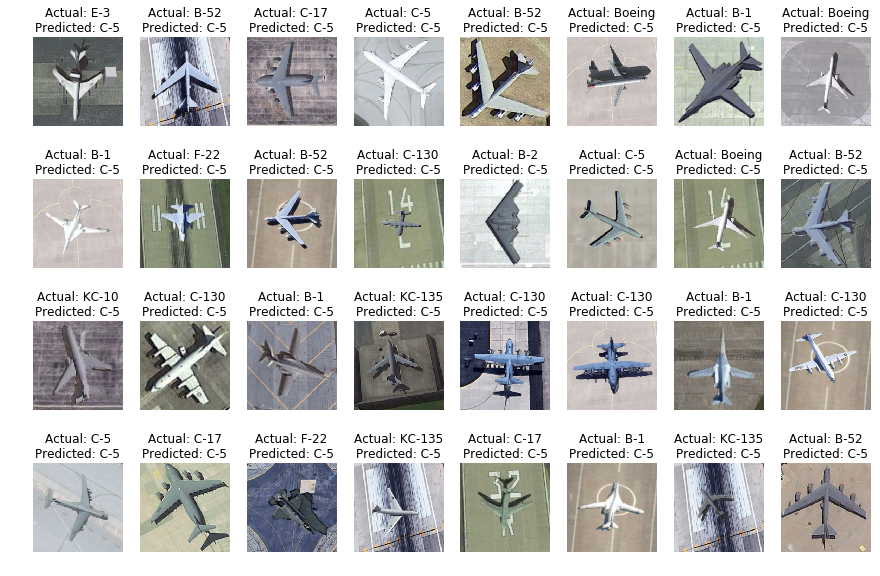

In [8]:
#Either I am doing something wrong 
#a) in passing the images to the model 
#b) or the model is set up wrong while predicting for fp16
#c) below is output of the most inaccurate run that I have had ...Can someone please check and help me debug of what I might be doing wrong
#d) Same way I can get fp32 going ... but need help is figuring out what am I doing wrong here 

dm = PlaneDataModule(train_batch_size=32, val_batch_size=32, data_dir='../data', seed=2)
#dm.prepare_data()
dm.setup()
image_count = 32
classes = dm.dataset.classes
# Get images as tensors for prediction.
predictions = []
for idx in range(image_count):
    trt_image = dm.val_dataset[idx][0].cuda().half()
    #trt_image = trt_image.cuda().half()
    #trt_image = trt_image.cuda()
    predict_class = torch.argmax(model_trt_fp16(trt_image))
    predictions.append(predict_class)

# Get images in a format expected by matplotlib for visualizing.
images = [
    np.transpose(dm.val_dataset[idx][0].numpy(), (1, 2, 0))
    for idx in range(image_count)
]

    
# Get labels for the respective indicies.
actuals = [
    dm.val_dataset[idx][1]
    for idx in range(image_count)
]

fig, axes = plt.subplots(nrows=4, ncols=8)
fig.set_figheight(10)
fig.set_figwidth(15)
axes = axes.flatten()

for ax, image, actual, prediction in zip(axes, images, actuals, predictions):
    prediction_label = classes[prediction]
    actual_label = classes[actual]
    ax.imshow(image)
    ax.set_title(f'Actual: {actual_label}\nPredicted: {prediction_label}')
    ax.axis('off')
